In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [68]:
df = pd.read_csv("daily_sales_french_bakery.csv", parse_dates=["ds"]).dropna()
df = df.drop("unit_price", axis=1)
df = df.groupby(["unique_id", "ds"]).sum().reset_index()
df

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0
...,...,...,...
57041,VIK BREAD,2022-09-26,0.0
57042,VIK BREAD,2022-09-27,0.0
57043,VIK BREAD,2022-09-28,0.0
57044,VIK BREAD,2022-09-29,0.0


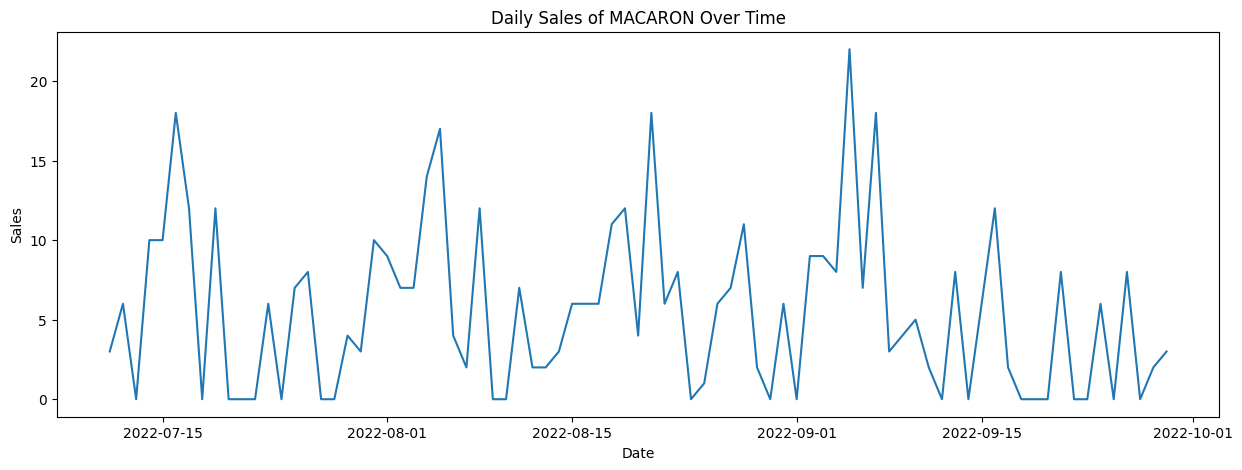

In [69]:
plt.figure(figsize=(15, 5))
plt.plot(df[df["unique_id"] == "MACARON"]["ds"], df[df["unique_id"] == "MACARON"]["y"])
plt.title("Daily Sales of MACARON Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [70]:
macaron_df = (
    df[df["unique_id"] == "MACARON"]
    .groupby("ds", as_index=True)["y"]
    .sum()
    .sort_index()
)
macaron_df.head()

ds
2022-07-11     3.0
2022-07-12     6.0
2022-07-13     0.0
2022-07-14    10.0
2022-07-15    10.0
Name: y, dtype: float64

In [71]:
y_daily = macaron_df
y_daily

ds
2022-07-11     3.0
2022-07-12     6.0
2022-07-13     0.0
2022-07-14    10.0
2022-07-15    10.0
              ... 
2022-09-25     0.0
2022-09-26     8.0
2022-09-27     0.0
2022-09-28     2.0
2022-09-29     3.0
Name: y, Length: 81, dtype: float64

In [ ]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    return result[1] < 0.05

is_stationary = check_stationarity(y_daily)
print(f"\n Time series is {'stationary' if is_stationary else 'non-stationary'}")

	1%: -3.5159766913976376
	5%: -2.898885703483903
	10%: -2.5866935058484217

 Time series is stationary


In [ ]:
horizon = 7
y_train = y_daily.iloc[:-horizon]
y_test = y_daily.iloc[-horizon:]

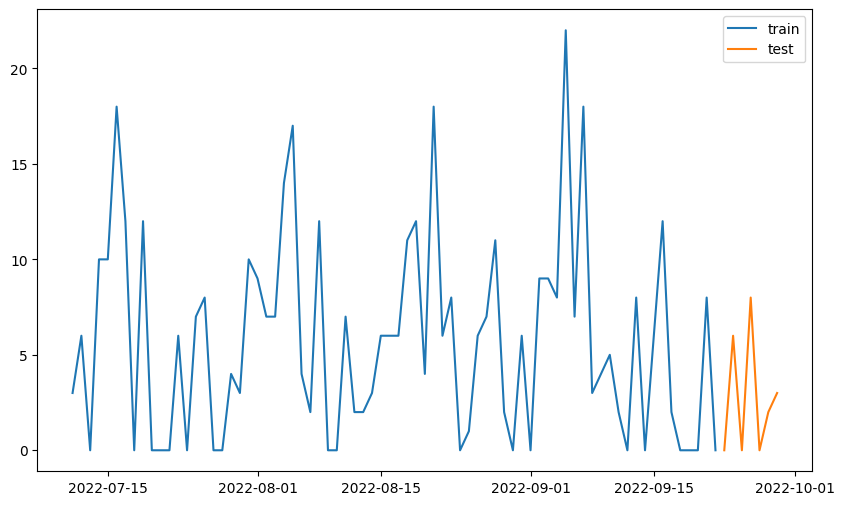

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train.values, label="train")
plt.plot(y_test.index, y_test.values, label="test")
plt.legend()
plt.show()

In [ ]:
auto_pdq = auto_arima(y_train,
                        start_p=0, start_q=0,
                        m=30, seasonal=True,
                        trace=True,
                        error_action="ignore",
                        suppress_warnings=True,
                        stepwise=False)

 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=460.104, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[30] intercept   : AIC=461.826, Time=0.25 sec
 ARIMA(0,0,0)(0,0,2)[30] intercept   : AIC=463.816, Time=0.61 sec
 ARIMA(0,0,0)(1,0,0)[30] intercept   : AIC=461.822, Time=0.32 sec
 ARIMA(0,0,0)(1,0,1)[30] intercept   : AIC=463.826, Time=0.29 sec
 ARIMA(0,0,0)(1,0,2)[30] intercept   : AIC=465.816, Time=1.02 sec
 ARIMA(0,0,0)(2,0,0)[30] intercept   : AIC=463.816, Time=1.04 sec
 ARIMA(0,0,0)(2,0,1)[30] intercept   : AIC=465.816, Time=0.91 sec
 ARIMA(0,0,0)(2,0,2)[30] intercept   : AIC=467.816, Time=0.91 sec
 ARIMA(0,0,1)(0,0,0)[30] intercept   : AIC=460.951, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=462.721, Time=0.35 sec
 ARIMA(0,0,1)(0,0,2)[30] intercept   : AIC=464.716, Time=0.92 sec
 ARIMA(0,0,1)(1,0,0)[30] intercept   : AIC=462.725, Time=0.43 sec
 ARIMA(0,0,1)(1,0,1)[30] intercept   : AIC=464.722, Time=0.40 sec
 ARIMA(0,0,1)(1,0,2)[30] intercept   : AIC=466.716, Time=1.00 sec
 ARIMA(0,0

In [78]:
print(auto_pdq.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   74
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -223.303
Date:                Thu, 05 Feb 2026   AIC                            458.605
Time:                        11:50:32   BIC                            472.430
Sample:                    07-11-2022   HQIC                           464.120
                         - 09-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.9048      0.505      5.756      0.000       1.916       3.894
ar.L1          1.4655      0.073     19.944      0.000       1.321       1.610
ar.L2         -0.9592      0.077    -12.400      0.0

In [79]:
model = ARIMA(y_train,
              order=auto_pdq.order,
              seasonal_order= auto_pdq.seasonal_order)

results = model.fit()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [80]:
forecast = results.get_forecast(steps=horizon)

y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()

y_pred.index = y_test.index
conf_int.index = y_test.index

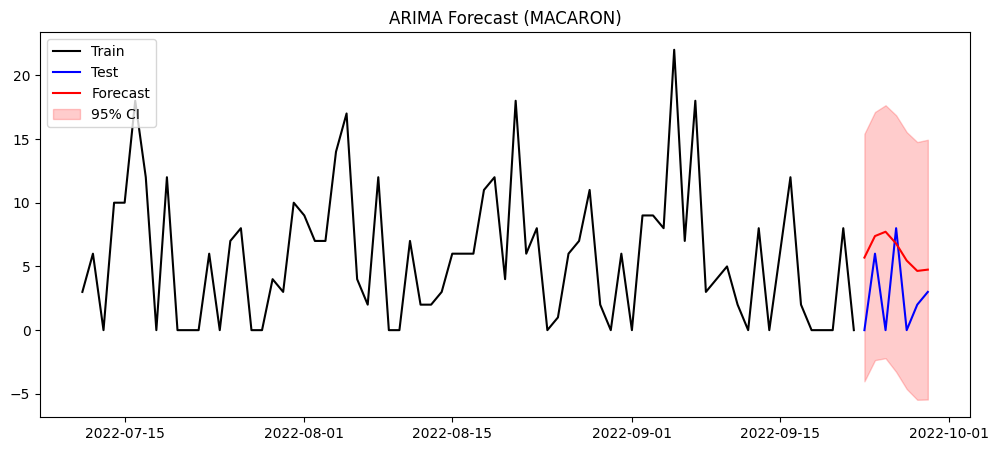

In [81]:
plt.figure(figsize=(12, 5))

plt.plot(y_train.index, y_train, label="Train", color="black")
plt.plot(y_test.index, y_test, label="Test", color="blue")
plt.plot(y_pred.index, y_pred, label="Forecast", color="red")

plt.fill_between(
    y_test.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    alpha=0.2,
    color="red",
    label="95% CI"
)

plt.legend()
plt.title("ARIMA Forecast (MACARON)")
plt.show()